In [1]:
import sys
import os


# Add the parent directory of 'scripts' to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import beneuro_pose_estimation.anipose.aniposeTools as aniposeTools

In [ ]:
import sleap_anipose as slap

In [ ]:

def calculate_reprojection_errors(session_dir, cameras=params.default_cameras):
    """Calculate reprojection errors between 3D predictions and 2D data"""
    session_name = session_dir.parent.name
    logger.info(f"\nAnalyzing session: {session_name}")
    
    # Load 3D predictions
    points_3d = load_3d_predictions(session_dir)
    if points_3d is None:
        return None
        
    # Load calibration data
    if session_name.split("_")[1] == "2025":  # Special case for 2025 sessions
        calib_file = config.calibration / "calibration_2025_03_12_11_45.toml"
        if not calib_file.exists():
            logger.error(f"Calibration file not found for 2025 sessions: {calib_file}")
            return None
    else:
        calib_file = aniposeTools.get_most_recent_calib(session_name)
        if calib_file is None:
            logger.error(f"Could not find calibration file for session {session_name}")
            return None
        
    # Calculate reprojections using slap.reproject
    reproj_output_file = session_dir / f"{session_name}_reprojections.h5"
    slap.reproject(
        p3d=str(session_dir / f"{session_name}_pose_estimation_combined.h5"),
        calib=str(calib_file),
        frames=(0, points_3d.shape[0]),
        fname=str(reproj_output_file)
    )
    
    # Load reprojections from file
    with h5py.File(reproj_output_file, "r") as f:
        reproj_output = [f[camera][:] for camera in cameras]
    
    # Load 2D predictions
    predictions_2d = load_2d_predictions(session_dir, cameras)
    if predictions_2d is None:
        return None
    
    # Calculate errors
    errors = {}
    for i, camera in enumerate(cameras):
        # Calculate Euclidean distance between reprojected and original points
        error = np.linalg.norm(reproj_output[i] - predictions_2d[i, ..., :2], axis=-1)
        errors[camera] = error
    
    # Calculate and print mean error per keypoint (averaged across all cameras)
    all_errors = np.stack(list(errors.values()), axis=0)  # Shape: (n_cameras, n_tracks, n_keypoints, n_frames)
    mean_error_per_keypoint = np.nanmean(all_errors, axis=(0, 1, 3))  # Average over cameras, tracks, and frames
    logger.info("\nMean reprojection error per keypoint (pixels):")
    for i, body_part in enumerate(params.body_parts):
        logger.info(f"  {body_part}: {mean_error_per_keypoint[i]:.3f}")
    
    # Calculate and print mean error per camera (averaged across all keypoints)
    mean_error_per_camera = np.nanmean(all_errors, axis=(1, 2, 3))  # Average over tracks, keypoints, and frames
    logger.info("\nMean reprojection error per camera (pixels):")
    for i, camera in enumerate(cameras):
        logger.info(f"  {camera}: {mean_error_per_camera[i]:.3f}")
    
    # Calculate and print mean error per keypoint per camera
    logger.info("\nMean reprojection error per keypoint per camera (pixels):")
    for i, body_part in enumerate(params.body_parts):
        logger.info(f"\n{body_part}:")
        for camera in cameras:
            if camera in errors:
                # Calculate mean error for this keypoint in this camera
                mean_error = np.nanmean(errors[camera][:, i, :])
                logger.info(f"  {camera}: {mean_error:.3f}")
    
    # Calculate detection percentage per keypoint per camera
    logger.info("\nDetection percentage per keypoint per camera:")
    for i, body_part in enumerate(params.body_parts):
        logger.info(f"\n{body_part}:")
        for camera in cameras:
            if camera in errors:
                # Count non-NaN values for this keypoint in this camera
                valid_detections = np.sum(~np.isnan(predictions_2d[i, :, i, :]))
                total_frames = predictions_2d[i, :, i, :].size
                detection_percentage = (valid_detections / total_frames) * 100
                logger.info(f"  {camera}: {detection_percentage:.1f}%")
    
    # Calculate overall statistics
    all_errors_flat = np.concatenate([e.flatten() for e in errors.values()])
    mean_error = np.nanmean(all_errors_flat)
    median_error = np.nanmedian(all_errors_flat)
    std_error = np.nanstd(all_errors_flat)
    
    logger.info(f"\nOverall reprojection error statistics (pixels):")
    logger.info(f"  Mean: {mean_error:.3f}")
    logger.info(f"  Median: {median_error:.3f}")
    logger.info(f"  Standard deviation: {std_error:.3f}")
    
    return {
        "per_camera": mean_error_per_camera,
        "per_keypoint": mean_error_per_keypoint,
        "overall": {
            "mean": float(mean_error),
            "median": float(median_error),
            "std": float(std_error)
        }
    }


In [4]:
import h5py
import json
from pathlib import Path
import pandas as pd
from beneuro_pose_estimation import params, set_logging
from beneuro_pose_estimation.config import _load_config
config = _load_config()

# Test with a specific session and camera
session = "M062_2025_03_21_14_00"
camera = "Camera_Back_Right"

# Path to the prediction file
slp_file = Path("/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/pose-estimation/tests/M062_2025_03_21_14_00_test/pose-estimation/Camera_Back_Right/M062_2025_03_21_14_00_Camera_Back_Right.slp.predictions.slp")

print(f"Checking file: {slp_file}")
print(f"File exists: {slp_file.exists()}")

if slp_file.exists():
    # Read the SLP file
    with h5py.File(slp_file, 'r') as f:
        # Print all top-level keys
        print("\nTop-level keys in the file:")
        print(list(f.keys()))
        
        # Check if provenance exists
        if 'provenance' in f:
            # Get provenance data
            provenance = json.loads(f['provenance'][()])
            
            print("\nProvenance information:")
            print("Model paths:", provenance.get('model_paths', []))
            print("SLEAP version:", provenance.get('sleap_version', ''))
            print("Predictor type:", provenance.get('predictor', ''))
            print("Timestamp:", provenance.get('finish_timestamp', ''))
            print("Command used:", provenance.get('command', ''))
            
            # Print all available provenance keys
            print("\nAll available provenance keys:")
            print(list(provenance.keys()))
        else:
            print("\nNo provenance information found in the file")
            
        # Print some basic file information
        print("\nFile structure:")
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                print(f"{key}: shape {f[key].shape}, dtype {f[key].dtype}")
            else:
                print(f"{key}: {type(f[key])}")

# Also check the training config
model_dir = config.models / camera
config_path = model_dir / "training_config.json"

print(f"\nChecking training config: {config_path}")
print(f"Config exists: {config_path.exists()}")

if config_path.exists():
    with open(config_path, 'r') as f:
        training_config = json.load(f)
        print("\nTraining config keys:")
        print(list(training_config.keys()))
        
        # Print some important training config details
        print("\nTraining config details:")
        print("Model type:", training_config.get('model_type', 'Not found'))
        print("Training data:", training_config.get('training_data', 'Not found'))
        print("Training parameters:", training_config.get('training_params', 'Not found'))


Checking file: /home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/pose-estimation/tests/M062_2025_03_21_14_00_test/pose-estimation/Camera_Back_Right/M062_2025_03_21_14_00_Camera_Back_Right.slp.predictions.slp
File exists: True

Top-level keys in the file:
['frames', 'instances', 'metadata', 'points', 'pred_points', 'suggestions_json', 'tracks_json', 'videos_json']

No provenance information found in the file

File structure:
frames: shape (100,), dtype [('frame_id', '<u8'), ('video', '<u4'), ('frame_idx', '<u8'), ('instance_id_start', '<u8'), ('instance_id_end', '<u8')]
instances: shape (100,), dtype [('instance_id', '<i8'), ('instance_type', 'u1'), ('frame_id', '<u8'), ('skeleton', '<u4'), ('track', '<i4'), ('from_predicted', '<i8'), ('score', '<f4'), ('point_id_start', '<u8'), ('point_id_end', '<u8'), ('tracking_score', '<f4')]
metadata: <class 'h5py._hl.group.Group'>
points: shape (0,), dtype [('x', '<f8'), ('y', '<f8'), ('visible', '?'), ('complete', '?')]
pred

In [5]:
def print_h5_structure(g, indent=0):
    spacer = "  " * indent
    for key in g:
        item = g[key]
        if isinstance(item, h5py.Dataset):
            print(f"{spacer}{key}: Dataset, shape={item.shape}, dtype={item.dtype}")
        else:
            print(f"{spacer}{key}/: Group")
            print_h5_structure(item, indent+1)
    # print attributes
    for attr_key, attr_val in g.attrs.items():
        print(f"{spacer}@{attr_key} = {attr_val}")

with h5py.File(slp_file, "r") as f:
    print_h5_structure(f["metadata"])


@format_id = 1.2
@json = b'{"version":"2.0.0","skeletons":[{"directed":true,"graph":{"name":"Skeleton-1","num_edges_inserted":20},"links":[{"edge_insert_idx":0,"key":0,"source":1,"target":4,"type":{"py/reduce":[{"py/type":"sleap.skeleton.EdgeType"},{"py/tuple":[1]}]}},{"edge_insert_idx":1,"key":0,"source":1,"target":7,"type":{"py/id":1}},{"edge_insert_idx":6,"key":0,"source":1,"target":9,"type":{"py/id":1}},{"edge_insert_idx":2,"key":0,"source":4,"target":11,"type":{"py/id":1}},{"edge_insert_idx":4,"key":0,"source":7,"target":13,"type":{"py/id":1}},{"edge_insert_idx":17,"key":0,"source":13,"target":15,"type":{"py/id":1}},{"edge_insert_idx":7,"key":0,"source":9,"target":16,"type":{"py/id":1}},{"edge_insert_idx":10,"key":0,"source":9,"target":17,"type":{"py/id":1}},{"edge_insert_idx":13,"key":0,"source":9,"target":18,"type":{"py/id":1}},{"edge_insert_idx":8,"key":0,"source":16,"target":0,"type":{"py/id":1}},{"edge_insert_idx":9,"key":0,"source":0,"target":2,"type":{"py/id":1}},{"edge_ins

In [6]:
import json
from pathlib import Path

def summarize_model_config(config_path):
    """
    Load a SLEAP training_config.json and print the most important settings:
      • Data/labels
      • Preprocessing
      • Model architecture
      • Training hyperparameters
      • Augmentation settings
    """
    config_path = Path(config_path)
    with open(config_path, "r") as f:
        cfg = json.load(f)

    data = cfg.get("data", {})
    labels = data.get("labels", {})
    print("=== Data & Labels ===")
    print("Training labels:", labels.get("training_labels"))
    print("Validation fraction:", labels.get("validation_fraction"))
    print("Using explicit indices?:", labels.get("split_by_inds", False))
    if labels.get("split_by_inds", False):
        print("  • Training idx count:", len(labels.get("training_inds", [])))
        print("  • Validation idx count:", len(labels.get("validation_inds", [])))

    prep = data.get("preprocessing", {})
    print("\n=== Preprocessing ===")
    print("Ensure RGB?", prep.get("ensure_rgb"))
    print("Ensure grayscale?", prep.get("ensure_grayscale"))
    print("Resize to target:", prep.get("resize_and_pad_to_target"),
          f"{prep.get('target_width')}×{prep.get('target_height')}")

    model = cfg.get("model", {})
    backbone = model.get("backbone", {}).get("unet", None)
    heads    = model.get("heads", {}).get("single_instance", {})
    print("\n=== Model Architecture ===")
    if backbone:
        print("UNet filters:", backbone.get("filters"),
              "rate:", backbone.get("filters_rate"),
              "output_stride:", backbone.get("output_stride"))
    print("Head sigma:", heads.get("sigma"),
          "output_stride:", heads.get("output_stride"))
    print("Part names:", ", ".join(heads.get("part_names", [])))

    opt = cfg.get("optimization", {})
    aug = opt.get("augmentation_config", {})
    print("\n=== Augmentation ===")
    print(" Rotate:", aug.get("rotate"),
          "±", aug.get("rotation_min_angle"), "to", aug.get("rotation_max_angle"))
    print(" Scale:", aug.get("scale"),
          aug.get("scale_min"), "to", aug.get("scale_max"))
    print(" Gaussian noise:", aug.get("gaussian_noise"),
          "σ=", aug.get("gaussian_noise_stddev"))

    print("\n=== Training Hyperparameters ===")
    print("Batch size:", opt.get("batch_size"),
          "Batches/epoch:", opt.get("batches_per_epoch"))
    print("Epochs:", opt.get("epochs"))
    lr_sched = opt.get("learning_rate_schedule", {})
    print("Initial LR:", opt.get("initial_learning_rate"))
    if lr_sched.get("reduce_on_plateau"):
        print(" LR reduce on plateau, factor:",
              lr_sched.get("reduction_factor"),
              "patience:", lr_sched.get("plateau_patience"))

    outputs = cfg.get("outputs", {})
    print("\n=== Outputs ===")
    print("Run name:", outputs.get("run_name"))
    print("Save visualizations?", outputs.get("save_visualizations"))

# Example usage:
model_cfg = "/mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/models/Camera_Back_Right/training_config.json"
summarize_model_config(model_cfg)


=== Data & Labels ===
Training labels: /mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/training/Camera_Back_Right/Camera_Back_Right.pkg.slp
Validation fraction: 0.1
Using explicit indices?: False

=== Preprocessing ===
Ensure RGB? False
Ensure grayscale? True
Resize to target: True 1280×720

=== Model Architecture ===
UNet filters: 32 rate: 1.5 output_stride: 4
Head sigma: 5.0 output_stride: 4
Part names: shoulder_center, left_shoulder, left_paw, right_shoulder, right_elbow, right_paw, hip_center, left_knee, left_ankle, left_foot, right_knee, right_ankle, right_foot, tail_base, tail_middle, tail_tip, left_elbow, left_wrist, right_wrist

=== Augmentation ===
 Rotate: True ± -15.0 to 15.0
 Scale: True 0.9 to 1.1
 Gaussian noise: True σ= 1.0

=== Training Hyperparameters ===
Batch size: 4 Batches/epoch: 200
Epochs: 200
Initial LR: 0.0001
 LR reduce on plateau, factor: 0.5 patience: 5

=== Outputs ===
Run name: 2503331_172100.single_instance.n=200
Save visualizations? True


In [8]:
model_cfg = "/mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/models/Camera_Back_Right/training_config.json"
summarize_model_config(model_cfg)

=== Data & Labels ===
Training labels:      /mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/training/Camera_Back_Right/Camera_Back_Right.pkg.slp
Validation fraction:  0.1
Split by indices?     False

=== Preprocessing ===
Ensure RGB?          False
Ensure grayscale?    True
Resize & pad?       True → 1280×720

=== Model Architecture ===
UNet filters:        32 (rate=1.5, stride=4)
Head σ (sigma):      5.0 (stride=4)
Keypoint names:      shoulder_center, left_shoulder, left_paw, right_shoulder, right_elbow, right_paw, hip_center, left_knee, left_ankle, left_foot, right_knee, right_ankle, right_foot, tail_base, tail_middle, tail_tip, left_elbow, left_wrist, right_wrist

=== Augmentation Settings ===
Rotation (°)     : [True, -15.0, 15.0]
Translation (px) : [False, -5, 5]
Scaling          : [True, 0.9, 1.1]
Uniform Noise    : [False, 0.0, 10.0]
Gaussian Noise   : [True, 5.0, 1.0]
Contrast (γ)     : [False, 0.5, 1.5]
Brightness       : [False, -10.0, 10.0]
Random Crop      :

In [10]:
import numpy as np
import sleap
def get_model_metrics(model_folder, test_gt_path=None, split="val"):
    """
    Load or compute metrics for a single SLEAP model.

    Args:
        model_folder (str or Path): Path to the folder that contains
            `training_config.json` and the model checkpoints.
        test_gt_path (str or Path, optional): If provided, will load this
            ground-truth `.slp` file and run predictor.predict() to compute
            metrics against it. Otherwise, uses sleap.load_metrics().
        split (str): which split to load metrics for ("val", "train", etc).

    Returns:
        dict: flattened metrics, with keys like "AP", "OKS", etc.
    """
    model_folder = Path(model_folder)
    metrics = {}

    if test_gt_path is not None:
        # Evaluate on a held-out ground-truth file
        predictor = sleap.load_model(str(model_folder))
        labels_gt = sleap.load_file(str(test_gt_path))
        labels_pr = predictor.predict(labels_gt)
        raw_metrics = sleap.nn.evals.evaluate(labels_gt, labels_pr)
    else:
        # Load precomputed metrics (validation by default)
        raw_metrics = sleap.load_metrics(str(model_folder), split=split)

    # Flatten: scalars stay, lists/arrays get averaged
    for key, val in raw_metrics.items():
        if isinstance(val, (float, int)):
            metrics[key] = val
        elif isinstance(val, (list, np.ndarray, pd.Series)):
            arr = np.asarray(val, dtype=float)
            # ignore NaNs when averaging
            metrics[key] = float(np.nanmean(arr)) if arr.size > 0 else np.nan
        else:
            # skip anything non-numeric
            continue

    return metrics


model_dir = "/mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/models/Camera_Back_Right"
metrics = get_model_metrics(model_dir)
print("Validation metrics:")
for k, v in metrics.items():
    print(f"  {k:10s}: {v:.4f}")

ValueError: could not convert string to float: '/mnt/rds/il620/projects/beneuro/live/processed/AnnotationParty/annotations/M051_2025_02_14_15_00_annotations/M051_2025_02_14_15_00_Camera_Back_Right_annotations/M051_2025_02_14_15_00_Camera_Back_Right_annotations.mp4'

In [11]:
raw_metrics = sleap.load_metrics(model_dir, split="val")

In [13]:
metrics = raw_metrics

In [14]:
print("Error distance (50%):", metrics["dist.p50"])
print("Error distance (90%):", metrics["dist.p90"])
print("Error distance (95%):", metrics["dist.p95"])

Error distance (50%): 7.897316647726468
Error distance (90%): 18.678995699412074
Error distance (95%): 24.302032534526255


In [15]:
import sleap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 0, 'Localization error (px)')

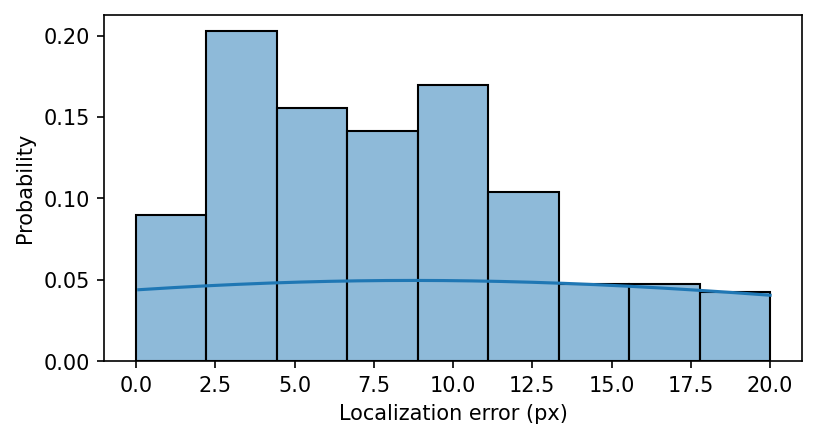

In [17]:
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics["dist.dists"].flatten(), binrange=(0, 20), kde=True, kde_kws={"clip": (0, 20)}, stat="probability")
plt.xlabel("Localization error (px)")

Text(0.5, 0, 'Object Keypoint Similarity')

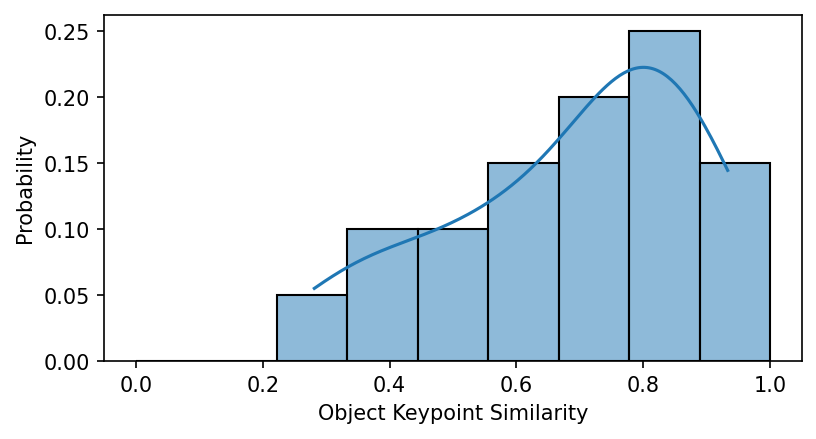

In [18]:
plt.figure(figsize=(6, 3), dpi=150, facecolor="w")
sns.histplot(metrics["oks_voc.match_scores"].flatten(), binrange=(0, 1), kde=True, kde_kws={"clip": (0, 1)}, stat="probability")
plt.xlabel("Object Keypoint Similarity")

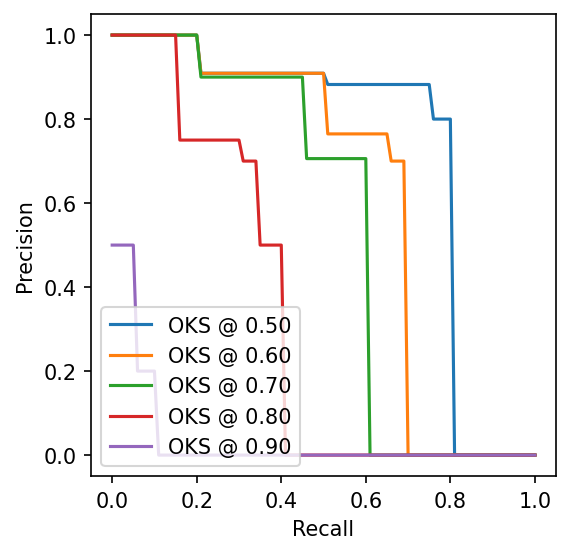

In [19]:
plt.figure(figsize=(4, 4), dpi=150, facecolor="w")
for precision, thresh in zip(metrics["oks_voc.precisions"][::2], metrics["oks_voc.match_score_thresholds"][::2]):
    plt.plot(metrics["oks_voc.recall_thresholds"], precision, "-", label=f"OKS @ {thresh:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")

In [20]:
print("mAP:", metrics["oks_voc.mAP"])
print("mAR:", metrics["oks_voc.mAR"])

mAP: 0.3953154475111377
mAR: 0.46499999999999997


In [ ]:
#  data visualisation and cleaning afterwards?


In [7]:
import json
from pathlib import Path

def summarize_model_config(config_path):
    """
    Load a SLEAP training_config.json and print the most important settings:
      • Data/labels
      • Preprocessing
      • Model architecture
      • Training hyperparameters
      • **All** augmentation settings (even those disabled)
      • Outputs
    """
    config_path = Path(config_path)
    with open(config_path, "r") as f:
        cfg = json.load(f)

    # — Data & Labels —
    data = cfg.get("data", {})
    labels = data.get("labels", {})
    print("=== Data & Labels ===")
    print("Training labels:     ", labels.get("training_labels"))
    print("Validation fraction: ", labels.get("validation_fraction"))
    print("Split by indices?    ", labels.get("split_by_inds", False))
    if labels.get("split_by_inds", False):
        print("  • # train idxs:    ", len(labels.get("training_inds", [])))
        print("  • # val   idxs:    ", len(labels.get("validation_inds", [])))

    # — Preprocessing —
    prep = data.get("preprocessing", {})
    print("\n=== Preprocessing ===")
    print("Ensure RGB?         ", prep.get("ensure_rgb"))
    print("Ensure grayscale?   ", prep.get("ensure_grayscale"))
    print(f"Resize & pad?       {prep.get('resize_and_pad_to_target')} "
          f"→ {prep.get('target_width')}×{prep.get('target_height')}")

    # — Model Architecture —
    model = cfg.get("model", {})
    backbone = model.get("backbone", {}).get("unet", {})
    heads    = model.get("heads", {}).get("single_instance", {})
    print("\n=== Model Architecture ===")
    if backbone:
        print("UNet filters:       ", backbone.get("filters"), 
              f"(rate={backbone.get('filters_rate')}, stride={backbone.get('output_stride')})")
    print("Head σ (sigma):     ", heads.get("sigma"), 
          f"(stride={heads.get('output_stride')})")
    print("Keypoint names:     ", ", ".join(heads.get("part_names", [])))

    # — Augmentation —
    aug = cfg.get("optimization", {}).get("augmentation_config", {})
    print("\n=== Augmentation Settings ===")
    # Group them by category for readability
    aug_categories = {
        "Rotation (°)": ["rotate", "rotation_min_angle", "rotation_max_angle"],
        "Translation (px)": ["translate", "translate_min", "translate_max"],
        "Scaling": ["scale", "scale_min", "scale_max"],
        "Uniform Noise": ["uniform_noise", "uniform_noise_min_val", "uniform_noise_max_val"],
        "Gaussian Noise": ["gaussian_noise", "gaussian_noise_mean", "gaussian_noise_stddev"],
        "Contrast (γ)": ["contrast", "contrast_min_gamma", "contrast_max_gamma"],
        "Brightness": ["brightness", "brightness_min_val", "brightness_max_val"],
        "Random Crop": ["random_crop", "random_crop_height", "random_crop_width"],
        "Random Flip": ["random_flip", "flip_horizontal"],
    }
    for title, keys in aug_categories.items():
        values = [aug.get(k) for k in keys]
        print(f"{title:17s}: {values}")

    # — Training Hyperparameters —
    opt = cfg.get("optimization", {})
    print("\n=== Training Hyperparameters ===")
    print("Batch size:         ", opt.get("batch_size"))
    print("Batches per epoch:  ", opt.get("batches_per_epoch"))
    print("Epochs:             ", opt.get("epochs"))
    print("Initial LR:         ", opt.get("initial_learning_rate"))
    lr_sched = opt.get("learning_rate_schedule", {})
    if lr_sched.get("reduce_on_plateau"):
        print("LR sched: reduce on plateau (factor="
              f"{lr_sched.get('reduction_factor')}, patience={lr_sched.get('plateau_patience')})")

    # — Outputs —
    outputs = cfg.get("outputs", {})
    print("\n=== Outputs ===")
    print("Run name:           ", outputs.get("run_name"))
    print("Save visualizations?", outputs.get("save_visualizations"))


In [2]:
aniposeTools.save_to_csv("M045_2024_11_20_11_15","/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5","/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv")

INFO:root:3D predictions saved to CSV at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv


In [3]:
import h5py
points3d = h5py.File("/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5", 'r')['points3d'][:]

In [9]:
file_path = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5"

In [5]:
points3d.shape

(30000, 1, 19, 3)

In [ ]:
with h5py.File(file_path, 'r') as h5_file:
    # Recursively list all groups and datasets
    def print_structure(name, obj):
        print(f"{name}: {type(obj)}")
    h5_file.visititems(print_structure)

frames: <class 'h5py._hl.dataset.Dataset'>
tracks: <class 'h5py._hl.dataset.Dataset'>


In [13]:
with h5py.File(file_path, 'r') as h5_file:
    print(h5_file["tracks"])

<HDF5 dataset "tracks": shape (1000, 1, 19, 3), type "<f8">


In [16]:
with h5py.File(file_path, 'r') as h5_file:
    print(h5_file["frames"][1])

1000


In [6]:
import sleap_anipose as slap
output_file = file_path = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5"
calib_file_path = "/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
start = 0 
end = 1000
session = "M045_2024_11_20_11_15"
project_dir = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15"
reproj_output_file = f"{project_dir}/{session}_reprojections_{start}_{end}.h5"


slap.reproject(p3d=output_file ,calib= calib_file_path,frames=(start, end),fname=reproj_output_file)
        # #  output: (n_cams, n_frames, n_tracks, n_nodes, 2)

array([[[[[ 397.74867329,  147.75311613],
          [ 527.32704281,  286.91513125],
          [ 423.77053046,  456.64745747],
          ...,
          [ 503.06126364,  375.72079149],
          [ 410.39835894,  413.70634969],
          [ 212.58215671,  358.95124271]]],


        [[[ 398.68185726,  148.16908685],
          [ 532.26708284,  280.46628432],
          [ 418.59956162,  466.18957258],
          ...,
          [ 514.12125845,  375.23826673],
          [ 425.04200453,  430.11045143],
          [ 213.04961782,  358.1500361 ]]],


        [[[ 399.60409424,  148.5911343 ],
          [ 536.35945998,  275.54044837],
          [ 414.97402914,  473.97762831],
          ...,
          [ 521.90942526,  375.48781898],
          [ 437.98428755,  441.07630998],
          [ 213.65924463,  357.64116965]]],


        ...,


        [[[ 399.37672017,  148.65217145],
          [ 536.29811565,  273.37218719],
          [ 407.2600634 ,  480.89923094],
          ...,
          [ 522.77636308,  381.

In [8]:
import h5py
with h5py.File(reproj_output_file , 'r') as h5_file:
    # Recursively list all groups and datasets
    def print_structure(name, obj):
        print(f"{name}: {type(obj)}")
    h5_file.visititems(print_structure)

Camera_Back_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Front_Left: <class 'h5py._hl.dataset.Dataset'>
Camera_Front_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Side_Left: <class 'h5py._hl.dataset.Dataset'>
Camera_Side_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Top_Left: <class 'h5py._hl.dataset.Dataset'>


In [9]:
with h5py.File(reproj_output_file, 'r') as h5_file:
    print(h5_file["Camera_Back_Right"])

<HDF5 dataset "Camera_Back_Right": shape (1000, 1, 19, 2), type "<f8">


In [3]:
session = "M045_2024_11_20_11_15"
aniposeTools.run_pose_estimation(session)

INFO:root:Running pose estimation on M045_2024_11_20_11_15
INFO:root:Using calibration folder: /mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25 for session M045_2024_11_20_11_35
/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml
INFO:root:Calibration file already exists: /home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml
INFO:root:Configuration file already exists at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/config.toml
Index(['fnum', 'shoulder_center_x', 'shoulder_center_y', 'shoulder_center_z',
       'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_paw_x',
       'left_paw_y', 'left_paw_z', 'right_shoulder_x', 'right_shoulder_y',
       'right_shoulder_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'right_paw_x', 'right_paw_y', 'right_paw_z', 'hip_center_x',
       'hi

<Figure size 2000x500 with 0 Axes>

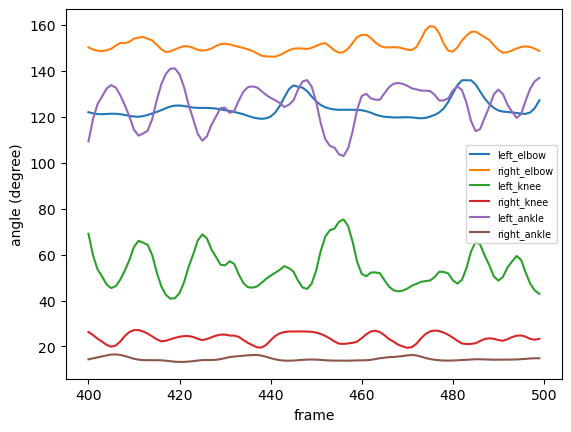

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_and_angles.csv"
project_dir = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

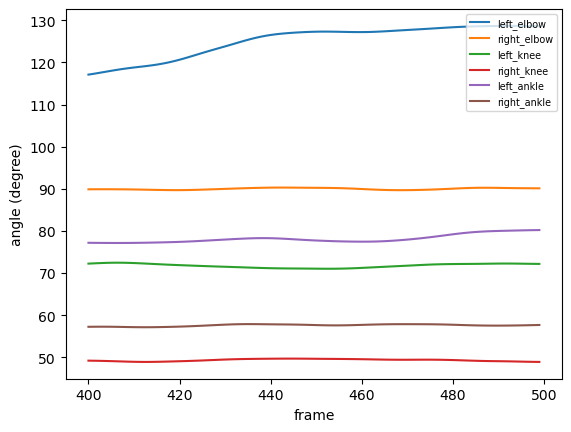

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M056/M056_2025_02_28_11_15/pose-estimation/M056_2025_02_28_11_15_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

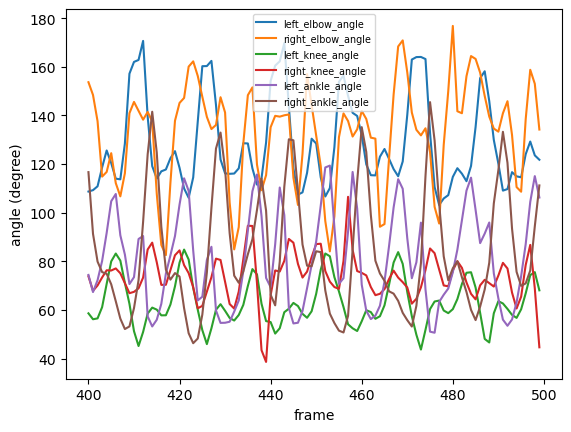

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M061/M061_2025_03_06_14_00/pose-estimation/M061_2025_03_06_14_00_3dpts_angles_interpolated.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

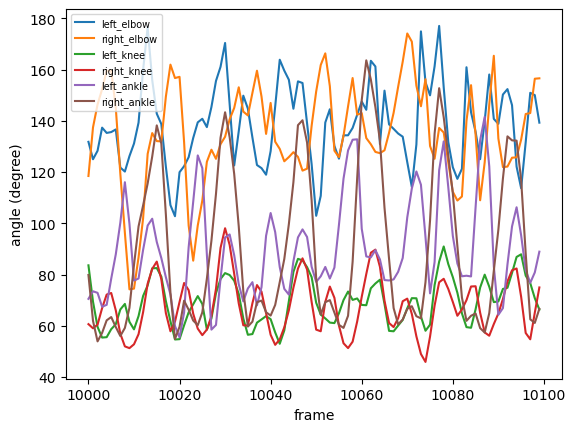

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[10000:10100]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

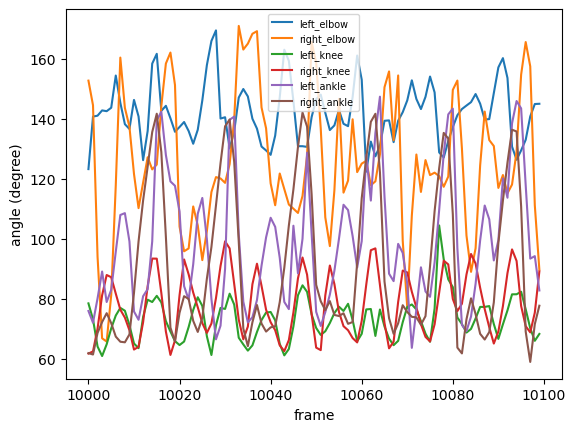

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[10000:10100]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

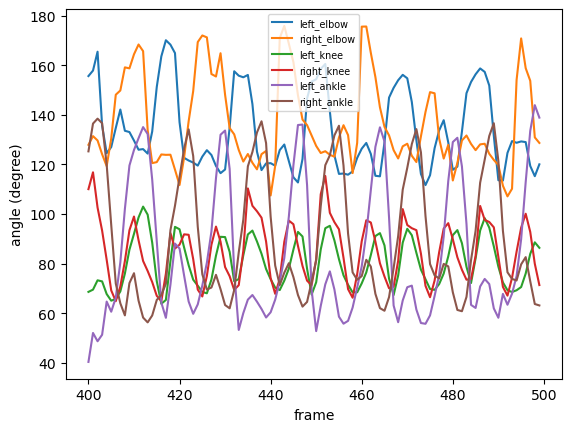

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

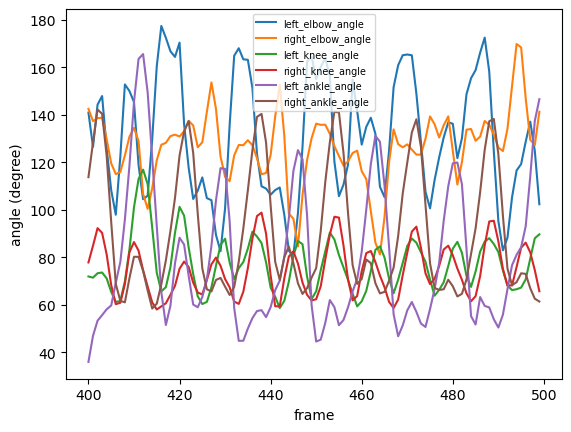

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

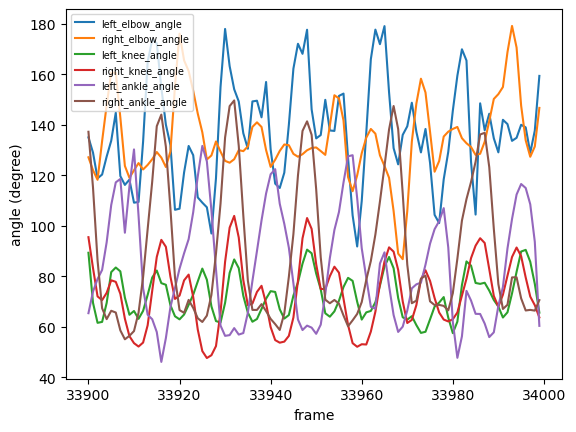

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
df = df[33900:34000]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

       left_elbow_angle  right_elbow_angle  left_knee_angle  right_knee_angle  \
33929        155.061773         129.394995        61.643258         65.701230   
33930        178.003396         125.717663        69.439592         85.708489   

       left_ankle_angle  right_ankle_angle  
33929         60.460696         108.794831  
33930         56.371999         134.984980  


<Figure size 2000x500 with 0 Axes>

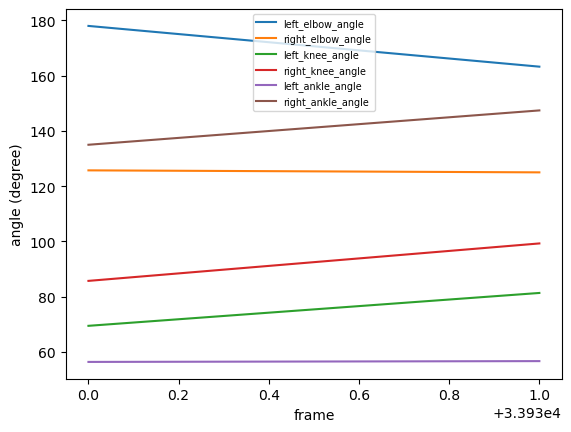

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
print(df[33929:33931])
df = df[33930:33932]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

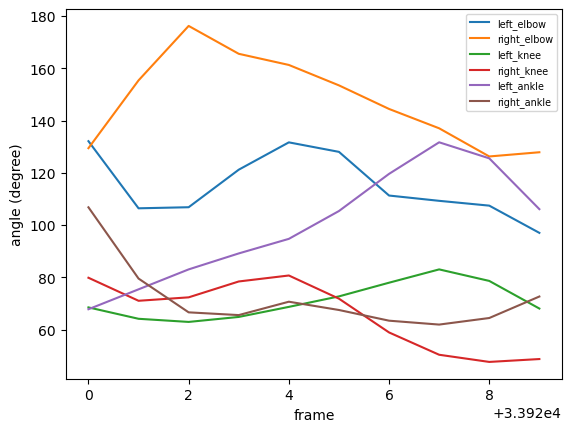

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[33920:33930]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

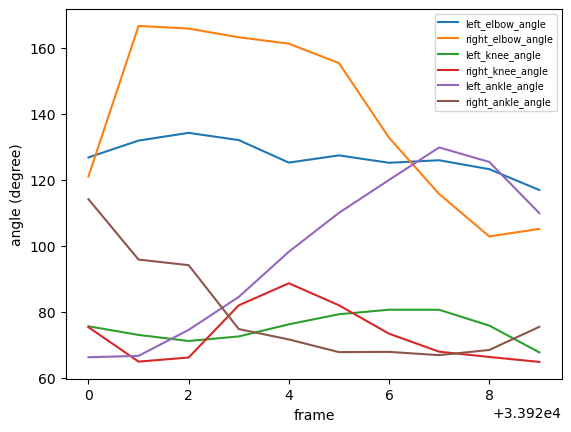

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
df = df[33920:33930]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

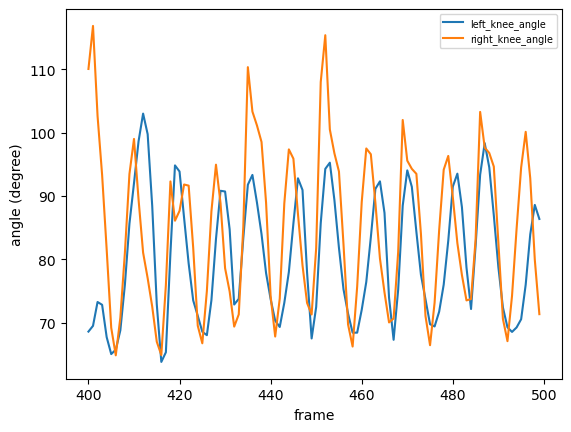

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_knee_angle', 'right_knee_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

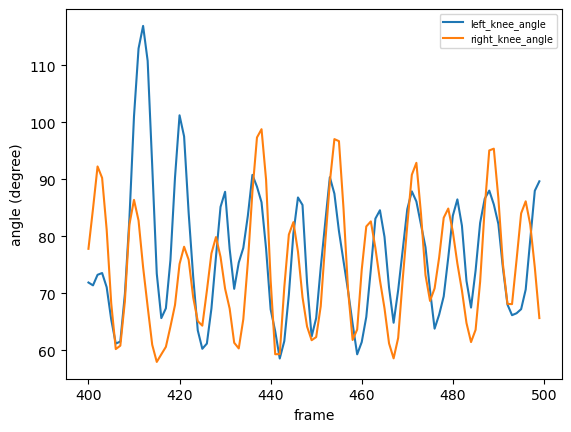

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_knee_angle', 'right_knee_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

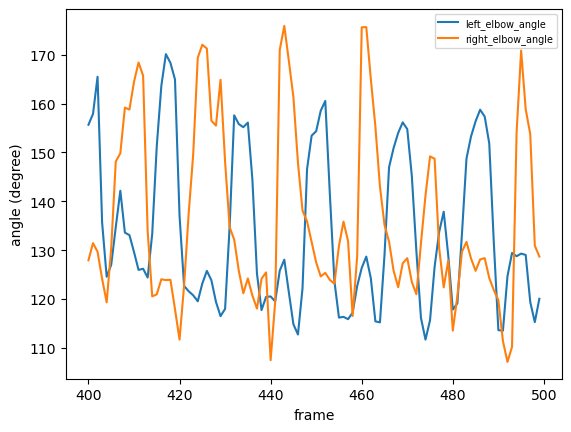

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_elbow_angle', 'right_elbow_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

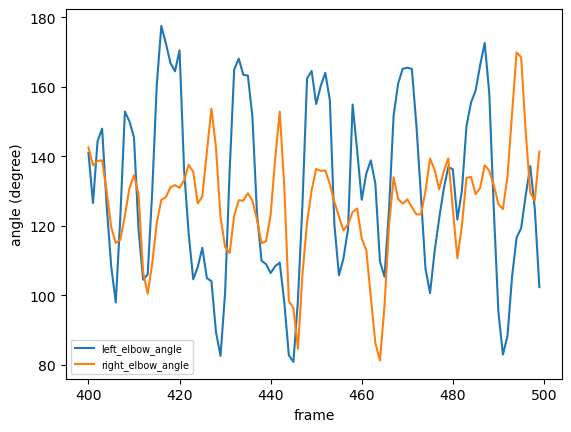

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_elbow_angle', 'right_elbow_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

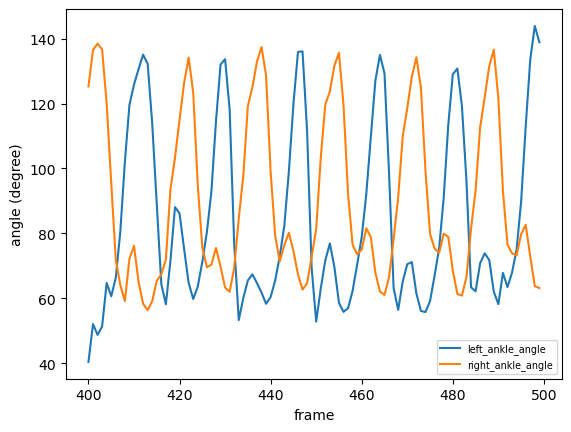

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/raw/M062/M062_2025_03_21_14_00/predictions/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_ankle_angle', 'right_ankle_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

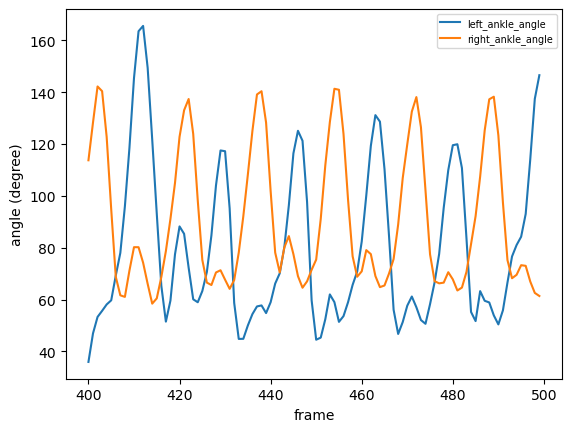

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles_padded.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
# df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
df = df[[ 'left_ankle_angle', 'right_ankle_angle']]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

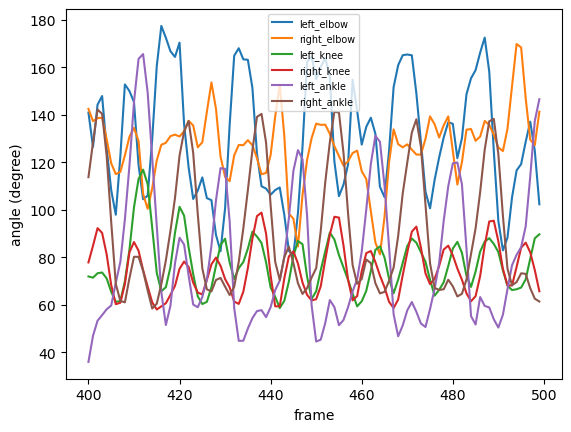

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

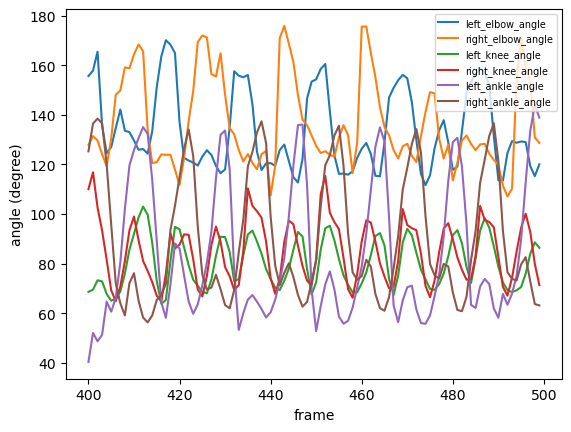

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle', 'right_knee_angle',"left_ankle_angle","right_ankle_angle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

<Figure size 2000x500 with 0 Axes>

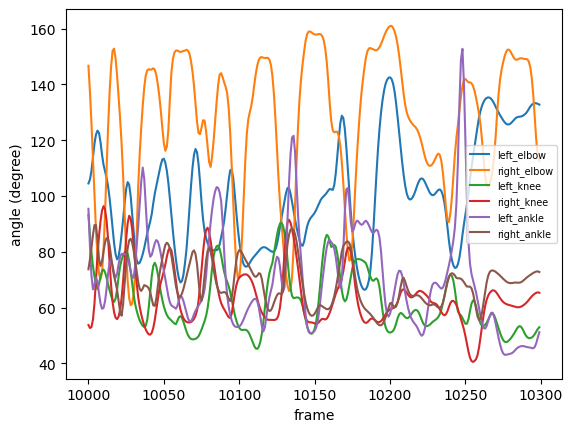

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/data/processed/M056/M056_2025_02_28_11_15/pose-estimation/M056_2025_02_28_11_15_3dpts_angles.csv"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[10000:10300]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
# plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

In [5]:
from beneuro_pose_estimation import evaluation as eval

In [ ]:
import beneuro_pose_estimation

In [6]:
csv_file = "/home/il620/beneuro_pose_estimation/data/processed/M061/M061_2025_03_06_14_00/pose-estimation/M061_2025_03_06_14_00_3dpts_angles_interpolated.csv"
df_stats = eval.compute_keypoint_missing_frame_stats(csv_file)
eval.print_angle_ranges_from_csv(csv_file, sep=",")
# out_dir = "/Users/il620/Desktop/data/raw/M062/M062_2025_03_21_14_00/"
# anim = create_3d_animation_from_csv(csv_file, out_dir, start_frame=400, end_frame=1000)
eval.print_angle_ranges_excluding_outliers(
csv_file, sep=",", method="percentile", pct_bounds=(0.05, 0.95)
)
eval.print_smoothed_angle_ranges_excluding_outliers(
        csv_file,
        sep=",",
        smoothing_window=7,   # median over 7 frames
        method="percentile",
        pct_bounds=(0.05, 0.95)
    )



# out_dir = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/"
# anim = eval.create_3d_animation_from_csv(csv_file, out_dir, start_frame=400, end_frame=500)


shoulder_center:    0 frames missing (  0.00%)
left_shoulder  :    0 frames missing (  0.00%)
left_paw       :    0 frames missing (  0.00%)
right_shoulder :    0 frames missing (  0.00%)
right_elbow    :    0 frames missing (  0.00%)
right_paw      :    0 frames missing (  0.00%)
hip_center     :    0 frames missing (  0.00%)
left_knee      :    0 frames missing (  0.00%)
left_ankle     :    0 frames missing (  0.00%)
left_foot      :    0 frames missing (  0.00%)
right_knee     :    0 frames missing (  0.00%)
right_ankle    :    0 frames missing (  0.00%)
right_foot     :    0 frames missing (  0.00%)
tail_base      :    0 frames missing (  0.00%)
tail_middle    :    0 frames missing (  0.00%)
tail_tip       :    0 frames missing (  0.00%)
left_elbow     :    0 frames missing (  0.00%)
left_wrist     :    0 frames missing (  0.00%)
right_wrist    :    0 frames missing (  0.00%)
right_knee_angle: min=  0.79°, max=178.86°, range=178.07°
left_knee_angle: min=  3.40°, max=166.23°, range=

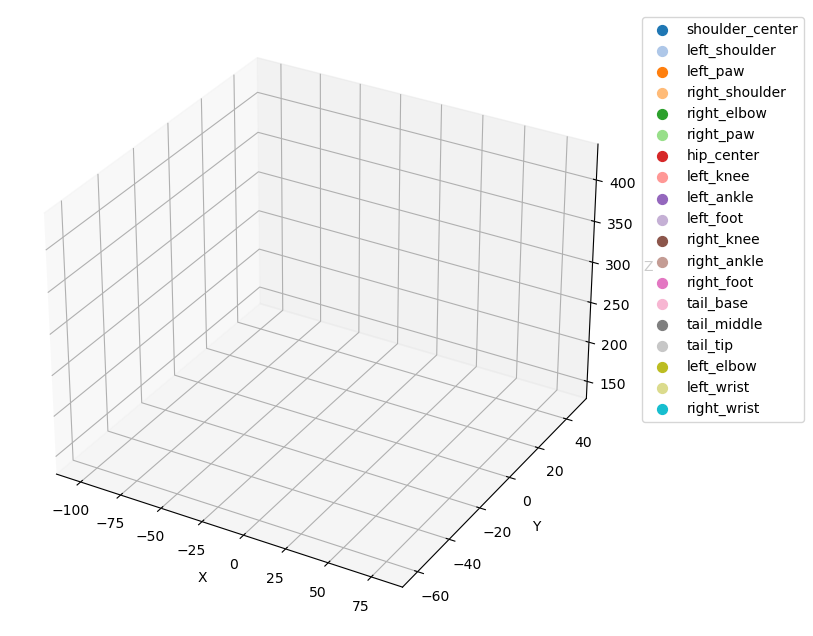

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x800 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/3d_animation__.mp4


In [2]:
csv_file = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/M062_2025_03_21_14_00_3dpts_angles.csv"

out_dir = "/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/"
anim = eval.create_3d_animation_from_csv(csv_file, out_dir, start_frame=400, end_frame=1000)

In [ ]:
session = "M045_2024_11_20_11_15"
aniposeTools.convert_2Dpred_to_h5(session)
# RDS/projects/beneuro/live/raw/M043/M043_2024_10_23_11_15/M043_2024_10_23_11_15_cameras

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.

Exporting to SLEAP Analysis file...
	track_names: 0
	node_names: 19
	edge_names: 18
	edge_inds: 18
	tracks: (30013, 19, 2, 1)
	track_occupancy: (1, 30013)
	point_scores: (30013, 19, 1)
	instance_scores: (30013, 1)
	tracking_scores: (30013, 1)
	labels_path: /home/il620/beneuro_pose_estimation/projects/predictions/M045_2024_11_20_11_15_Camera_Top_Left.slp.predictions.slp
	video_path: /mnt/rds/bb2020/projects/beneuro/live/raw/M045/M045_2024_11_20_11_15/Recording_2024-11-20T111527/Camera_0.avi
	video_ind: 0
	provenance: {"model_paths": ["/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/models/h1_new_setup/Camera_Top_Left/training_config.json"], "predictor": "SingleInstancePredictor", "sleap_version": "1.3.4", "platform": "Linux-5.15.0-117-generic-x86_64-with-debian-bullseye-sid", "command": "/home/il620/miniconda3/

In [2]:
calib_file_path = aniposeTools.get_most_recent_calib("M045_2024_11_20_11_15")

INFO:root:Using calibration folder: /mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_09_05_13_10 for session M045_2024_11_20_11_15
/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_09_05_13_10.toml
/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_09_05_13_10/Recording_2024-09-05T131252/Camera_4.avi


 13%|███▍                       | 2322/18001 [00:07<00:50, 310.09it/s]


KeyboardInterrupt: 

In [6]:
import h5py
h5_analysis_file = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_Camera_Back_Right.analysis.h5"
with h5py.File(h5_analysis_file, 'r') as f: 
        print(f['tracks'].shape)

(1, 2, 19, 30013)


In [4]:
import numpy as np

In [5]:
idx_cam_0 = np.load("/home/il620/beneuro_pose_estimation/data/processed/M062/M062_2025_03_21_14_00/pose-estimation/Camera_Top_Left/Camera_0_interp_idxs.npy")

In [6]:
idx_cam_0

array([ 39715,  39718,  39721,  39725,  39728,  39731,  39734,  39737,
        39743,  39746,  39749,  39752,  39756,  39759,  39762,  39765,
        39768,  39793, 121357, 121360, 121363, 121366, 121372, 121382,
       121391, 121395, 121398, 121401, 121403, 121404, 121405, 121406,
       121407, 121408, 121409, 121410, 121411, 121412, 121413, 121414,
       121415, 121416, 121417, 121418, 121419, 121420, 121421, 121422,
       121423, 121424, 121425, 121426, 121427, 121428, 121429, 121430,
       121431, 121432, 121433, 121434, 121435, 121436, 121437, 121438,
       121439, 121440, 121441, 121445, 203142, 203145, 203148, 203164,
       203167, 203170, 203173, 203176, 203179, 203182, 203186, 203189,
       203192, 203195, 203198, 203201, 203207, 203214, 203217, 203220,
       203226, 284918, 284921, 284946, 284949, 284952, 284955, 284958,
       284962, 284965, 284968, 284971, 284977, 284981, 284984, 284986,
       284993, 284996, 284999, 366603, 366609, 366612, 366615, 366618,
      

In [2]:
recent_calib_folder = "/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25/Recording_2024-11-20T113135"
calib_file_path = "/home/il620/beneuro_pose_estimation/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
aniposeTools.get_calib_file(recent_calib_folder, calib_file_path)

/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25/Recording_2024-11-20T113135/Camera_4.avi


  4%|█▏                           | 715/18013 [00:08<03:33, 81.00it/s]


KeyboardInterrupt: 

In [ ]:
calib_file_path = aniposeTools.get_most_recent_calib(session)

In [4]:
import h5py
fname = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_1000_2000.h5"
with h5py.File(fname, 'r') as f:
    print(f.keys())  # List datasets in the file
    print(f["tracks"].shape)
    # if 'points3d' in f:
    #     print(f['points3d'].shape)  # Check the shape of the dataset
    # else:
    #     print("Dataset 'points3d' is missing.")

<KeysViewHDF5 ['frames', 'tracks']>
(1000, 1, 19, 3)


In [2]:
calib_file_path = "/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
session = "M045_2024_11_20_11_15"
project_dir = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/{session}"
aniposeTools.compute_3Dpredictions(session, project_dir, calib_file_path)

/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15
0, 1000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5018.27it/s]


INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5
1000, 2000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5910.69it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_1000_2000.h5
2000, 3000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7392.81it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_2000_3000.h5
3000, 4000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5600.60it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_3000_4000.h5
4000, 5000


100%|█████████████████████████| 19000/19000 [00:05<00:00, 3176.35it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_4000_5000.h5
5000, 6000


100%|█████████████████████████| 19000/19000 [00:06<00:00, 2970.04it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_5000_6000.h5
6000, 7000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 6284.26it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_6000_7000.h5
7000, 8000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8809.36it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_7000_8000.h5
8000, 9000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 6385.94it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_8000_9000.h5
9000, 10000


100%|█████████████████████████| 19000/19000 [00:11<00:00, 1604.24it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_9000_10000.h5
10000, 11000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 6488.91it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_10000_11000.h5
11000, 12000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7991.46it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_11000_12000.h5
12000, 13000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8099.09it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_12000_13000.h5
13000, 14000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8115.26it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_13000_14000.h5
14000, 15000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7779.54it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_14000_15000.h5
15000, 16000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7759.30it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_15000_16000.h5
16000, 17000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8021.12it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_16000_17000.h5
17000, 18000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8893.93it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_17000_18000.h5
18000, 19000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7711.55it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_18000_19000.h5
19000, 20000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8707.05it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_19000_20000.h5
20000, 21000


100%|██████████████████████████| 19000/19000 [02:39<00:00, 118.90it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_20000_21000.h5
21000, 22000


100%|██████████████████████████| 19000/19000 [01:09<00:00, 275.36it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_21000_22000.h5
22000, 23000


100%|███████████████████████████| 19000/19000 [06:54<00:00, 45.82it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_22000_23000.h5
23000, 24000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5751.37it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_23000_24000.h5
24000, 25000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5679.28it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_24000_25000.h5
25000, 26000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8790.07it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_25000_26000.h5
26000, 27000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8602.34it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_26000_27000.h5
27000, 28000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 6148.64it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_27000_28000.h5
28000, 29000


100%|█████████████████████████| 19000/19000 [00:04<00:00, 3805.30it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_28000_29000.h5
29000, 30000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8909.35it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_29000_30000.h5
30000, 30013


100%|██████████████████████████████| 247/247 [00:00<00:00, 372.00it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_30000_30013.h5


KeyError: "Unable to open object (object 'points3d' doesn't exist)"

In [3]:
import numpy as np
session = "M045_2024_11_20_11_15"
project_dir = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/{session}"
windows = np.arange(0, 30013, 1000)
aniposeTools.combine_h5_files(session,windows, project_dir)

INFO:root:Combined 3D predictions saved at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5


In [5]:
aniposeTools.save_to_csv(session,f"{project_dir}/{session}_pose_estimation_combined.h5", f"{project_dir}/{session}_3d_predictions.csv")
        

INFO:root:3D predictions saved to CSV at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv


In [ ]:

# add angles
# see what intermediate files could be deleted 


